<a href="https://colab.research.google.com/github/parinya-ao/project_deep_learning/blob/main/deep_learn_eth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# prepare data

In [1]:
# !pip install d2l==1.0.3
!pip install yfinance
# !pip install torch==1.13.1
# !pip install matplotlib
!pip install tqdm==4.67.1
!pip install torchvision
# !pip install functools0
import yfinance as yf
import os
import random
import IPython
# import functools0
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from pathlib import Path

# Import torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

# import pandas
import pandas as pd

# import type
from typing import Union, List

# d2l lib for learning
# from d2l import torch as d2l

# select device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Fetch data

In [2]:
def fetch_data(symbol: Union[str, List[str]] = "ETH-USD",
               period: str = "max",
               interval: str = "1d",
               auto_adjust: bool = True) -> pd.DataFrame:

    # Download the data from Yahoo Finance
    df = yf.download(symbol, period=period, interval=interval, group_by='symbol')

    # Reset index
    df = df.reset_index()

    # Flatten columns - ใช้เฉพาะส่วนที่สอง (Price) หรือ Date
    new_columns = []
    for col in df.columns:
        if col[0] == 'Date' or col[1] == '':
            new_columns.append('Date')
        else:
            new_columns.append(col[1])  # เอาแค่ 'Open', 'High', 'Low', etc.

    df.columns = new_columns

    return df
data = fetch_data()
print(data)

/tmp/ipython-input-1750729491.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, period=period, interval=interval, group_by='symbol')
[*********************100%***********************]  1 of 1 completed

           Date         Open         High          Low        Close  \
0    2017-11-09   308.644989   329.451996   307.056000   320.884003   
1    2017-11-10   320.670990   324.717987   294.541992   299.252991   
2    2017-11-11   298.585999   319.453003   298.191986   314.681000   
3    2017-11-12   314.690002   319.153015   298.513000   307.907990   
4    2017-11-13   307.024994   328.415009   307.024994   316.716003   
...         ...          ...          ...          ...          ...   
2892 2025-10-10  4369.065430  4395.570801  3460.222412  3843.008789   
2893 2025-10-11  3840.960449  3882.241455  3652.790039  3750.611572   
2894 2025-10-12  3750.946045  4195.397461  3701.478271  4164.427734   
2895 2025-10-13  4164.049316  4292.845703  4061.224609  4245.467773   
2896 2025-10-15  4126.726074  4143.382324  4079.098633  4104.062500   

           Volume  
0       893249984  
1       885985984  
2       842300992  
3      1613479936  
4      1041889984  
...           ...  
2892  9

In [3]:
from typing import Union, List, Tuple
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import TensorDataset, DataLoader

import numpy as np

# prepare data
def prepare_data(df: pd.DataFrame,
                 features=['Open','High','Low','Close','Volume'],
                 target='Close', sequence_length=60, train_split=0.8):

    data = df[features].values.astype(np.float32)
    target_data = df[target].values.reshape(-1, 1).astype(np.float32)

    N = len(df)
    n_samples = N - sequence_length
    train_len = int(n_samples * train_split)
    fit_end = sequence_length + train_len   # ครอบคลุมหน้าต่างล้าหลังของ train

    scaler_X = MinMaxScaler().fit(data[:fit_end])
    scaler_y = MinMaxScaler().fit(target_data[:fit_end])

    data_scaled = scaler_X.transform(data)
    target_scaled = scaler_y.transform(target_data)

    # ทำ sequences
    X, y = [], []
    for i in range(sequence_length, len(data_scaled)):
        X.append(data_scaled[i-sequence_length:i])
        y.append(target_scaled[i])
    X = np.array(X); y = np.array(y)

    # แบ่งตามจำนวน sample
    X_train, X_test = X[:train_len], X[train_len:]
    y_train, y_test = y[:train_len], y[train_len:]

    # ไปยัง device
    X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
    X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

    return X_train, y_train, X_test, y_test, scaler_X, scaler_y


In [4]:
# test fetch data from yahoo finance
symbol = ["ETH-USD"]
data = fetch_data(symbol)

/tmp/ipython-input-1750729491.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, period=period, interval=interval, group_by='symbol')
[*********************100%***********************]  1 of 1 completed


In [5]:
data

,Date,Open,High,Low,Close,Volume
0,2017-11-09,308.644989,329.451996,307.056000,320.884003,893249984
1,2017-11-10,320.670990,324.717987,294.541992,299.252991,885985984
2,2017-11-11,298.585999,319.453003,298.191986,314.681000,842300992
3,2017-11-12,314.690002,319.153015,298.513000,307.907990,1613479936
4,2017-11-13,307.024994,328.415009,307.024994,316.716003,1041889984
...,...,...,...,...,...,...
2892,2025-10-10,4369.065430,4395.570801,3460.222412,3843.008789,97736621123
2893,2025-10-11,3840.960449,3882.241455,3652.790039,3750.611572,62475475938
2894,2025-10-12,3750.946045,4195.397461,3701.478271,4164.427734,61216174681
2895,2025-10-13,4164.049316,4292.845703,4061.224609,4245.467773,50253782420


In [6]:
# _dntk.DeepnoteChart(data, """{"layer":[{"layer":[{"layer":[{"mark":{"clip":true,"type":"bar","color":"#2266D3","tooltip":true},"encoding":{"x":{"axis":{"grid":false},"sort":"ascending","type":"temporal","field":"Date","scale":{"type":"linear"},"timeUnit":"yearmonthdate","bandPosition":0},"y":{"axis":{"format":{"type":"default","decimals":null},"formatType":"numberFormatFromNumberType"},"type":"quantitative","field":"Close","scale":{"type":"linear"},"format":{"type":"default","decimals":null},"aggregate":"sum","formatType":"numberFormatFromNumberType"},"color":{"type":"nominal","datum":"Close","scale":{"range":["#2266D3"],"domain":["Close"]}},"xOffset":{"datum":"series_0"}},"transform":[]}]}],"resolve":{"scale":{"color":"independent"}}}],"title":"","config":{"legend":{"disable":false}},"$schema":"https://vega.github.io/schema/vega-lite/v5.json","encoding":{},"usermeta":{"seriesNames":["Close"],"seriesOrder":[0],"specSchemaVersion":2,"tooltipDefaultMode":true}}""", attach_selection=True, filters='[]')

NameError: name '_dntk' is not defined

In [7]:
print(data.columns)
print(data.size)

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')
17382


# Model

In [8]:
# ref: https://github.com/NimaVahdat/ETH_Price_Prediction/blob/main/Networks/networks.py
# implement recurrent nerual network and LSTM
class LSTM_model(nn.Module):
    def __init__(self, input_dimension, hidden_dimension, output_dimension, n_layers, dropout_rate):
        super(LSTM_model, self).__init__()

        # บันทึก parameters
        self.hidden_dimension = hidden_dimension
        self.n_layers = n_layers

        # LSTM layers
        self.lstm = nn.LSTM(
            input_dimension,
            hidden_dimension,
            n_layers,
            dropout=dropout_rate if n_layers > 1 else 0,
            batch_first=True,
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dimension, output_dimension)

        # Dropout
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # LSTM forward pass
        output, (hidden, cell) = self.lstm(x)

        # ใช้ hidden state ของ layer สุดท้าย
        hidden = self.dropout(hidden[-1])

        # Prediction
        prediction = self.fc(hidden)

        return prediction

# train

In [16]:

# setup hyper parameter
input_dimension = 5
hidden_dimension = 64
output_dimension = 1
n_layers = 2
dropout_rate = 0.3
max_epoch = 750
lr= 0.00001
batch_size = 256

# define model
model = LSTM_model(input_dimension=input_dimension,hidden_dimension=hidden_dimension,
output_dimension=output_dimension, n_layers = n_layers, dropout_rate= dropout_rate
).to(device)

# load data
df = fetch_data(period="max")
X_train, y_train, X_test, y_test, scaler_X, scaler_y = prepare_data(
    df,
    sequence_length=60,
    train_split=0.8
)
train_n = int(len(X_train) * 0.8) if len(X_train) > 1 else len(X_train)
print(f"total data = {train_n}")
# training_data
X_tr = X_train[:train_n].cpu()
y_tr = y_train[:train_n].cpu()
# valide
X_val = X_train[train_n:].cpu() if train_n < len(X_train) else X_train[:0].cpu()
y_val = y_train[train_n:].cpu() if train_n < len(y_train) else y_train[:0].cpu()

# define train dataset
train_ds = TensorDataset(X_tr, y_tr)
# define test dataset
val_ds = TensorDataset(X_val, y_val) if len(X_val) > 0 else None

# define train to model
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
# test dataset
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False) if val_ds is not None else None

# define loss function
loss_fn = torch.nn.MSELoss()
otm = torch.optim.Adam(model.parameters(), lr=lr)


/tmp/ipython-input-1750729491.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, period=period, interval=interval, group_by='symbol')
[*********************100%***********************]  1 of 1 completed


total data = 1815


In [17]:


# train จริงๆ
# Training Loop
best_val_loss = float('inf')
train_losses = []
val_losses = []

for epoch in range(max_epoch):
    # ========== Training ==========
    model.train()
    train_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # Forward pass
        y_pred = model(X_batch)
        loss_value = loss_fn(y_pred, y_batch)

        # Backward pass
        otm.zero_grad()
        loss_value.backward()
        otm.step()

        train_loss += loss_value.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # ========== Validation ==========
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = model(X_batch)
            loss_value = loss_fn(y_pred, y_batch)
            val_loss += loss_value.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_lstm_model.pth')

    # Print progress
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{max_epoch}] - Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')

print(f'\nTraining completed! Best Val Loss: {best_val_loss:.6f}')

# Load best model
model.load_state_dict(torch.load('best_lstm_model.pth'))

Epoch [5/750] - Train Loss: 0.223014, Val Loss: 0.361630
Epoch [10/750] - Train Loss: 0.216526, Val Loss: 0.352276
Epoch [15/750] - Train Loss: 0.209328, Val Loss: 0.343228
Epoch [20/750] - Train Loss: 0.203824, Val Loss: 0.334360
Epoch [25/750] - Train Loss: 0.198320, Val Loss: 0.325614
Epoch [30/750] - Train Loss: 0.192245, Val Loss: 0.316935
Epoch [35/750] - Train Loss: 0.187035, Val Loss: 0.308253
Epoch [40/750] - Train Loss: 0.179992, Val Loss: 0.299497
Epoch [45/750] - Train Loss: 0.175019, Val Loss: 0.290647
Epoch [50/750] - Train Loss: 0.168890, Val Loss: 0.281624
Epoch [55/750] - Train Loss: 0.163148, Val Loss: 0.272411
Epoch [60/750] - Train Loss: 0.157283, Val Loss: 0.262953
Epoch [65/750] - Train Loss: 0.151709, Val Loss: 0.253222
Epoch [70/750] - Train Loss: 0.143935, Val Loss: 0.243187
Epoch [75/750] - Train Loss: 0.138308, Val Loss: 0.232819
Epoch [80/750] - Train Loss: 0.131551, Val Loss: 0.222067
Epoch [85/750] - Train Loss: 0.125709, Val Loss: 0.210913
Epoch [90/750] 

<All keys matched successfully>

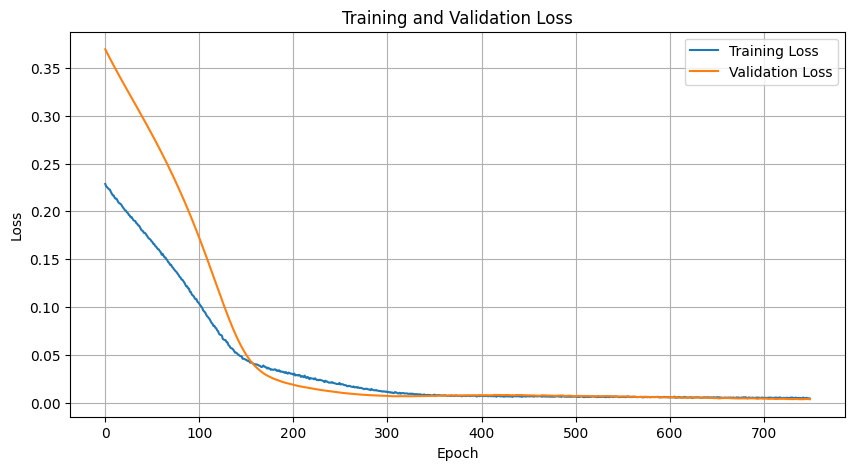

In [18]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

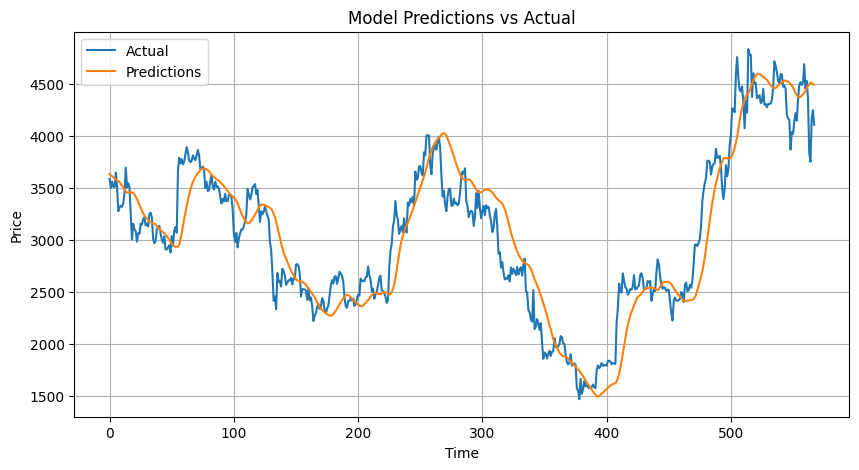

In [19]:
# Evaluate the model on the test set
model.eval()
predictions = []
actual = []

with torch.no_grad():
    for i in range(len(X_test)):
        X_sample = X_test[i].unsqueeze(0)  # Add batch dimension
        y_sample = y_test[i]
        y_pred = model(X_sample)
        predictions.append(y_pred.cpu().numpy())
        actual.append(y_sample.cpu().numpy())

predictions = np.array(predictions).reshape(-1, 1)
actual = np.array(actual).reshape(-1, 1)

# Inverse transform to get actual values
predictions = scaler_y.inverse_transform(predictions)
actual = scaler_y.inverse_transform(actual)

# Plot predictions vs actual
plt.figure(figsize=(10, 5))
plt.plot(actual, label='Actual')
plt.plot(predictions, label='Predictions')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Model Predictions vs Actual')
plt.legend()
plt.grid(True)
plt.show()

📊 ETH-USD Price Prediction Results
Total data points: 2,897 days
Training data: 2,269 days
Testing data: 568 days

📈 Model Accuracy:
RMSE: $286.01
MAE:  $217.23
MAPE: 7.40%

📋 Prediction Examples (First 10 days of Test Set):
----------------------------------------------------------------------
Index    Actual Price    Predicted Price Difference     
----------------------------------------------------------------------
1        $    3,587.50 $    3,634.33 $      -46.82
2        $    3,500.12 $    3,621.45 $     -121.34
3        $    3,561.29 $    3,611.25 $      -49.96
4        $    3,511.81 $    3,601.89 $      -90.09
5        $    3,507.94 $    3,592.26 $      -84.31
6        $    3,647.86 $    3,580.96 $       66.89
7        $    3,505.03 $    3,571.56 $      -66.53
8        $    3,277.23 $    3,564.71 $     -287.47
9        $    3,311.44 $    3,555.28 $     -243.84
10       $    3,330.04 $    3,539.55 $     -209.51
------------------------------------------------------------------

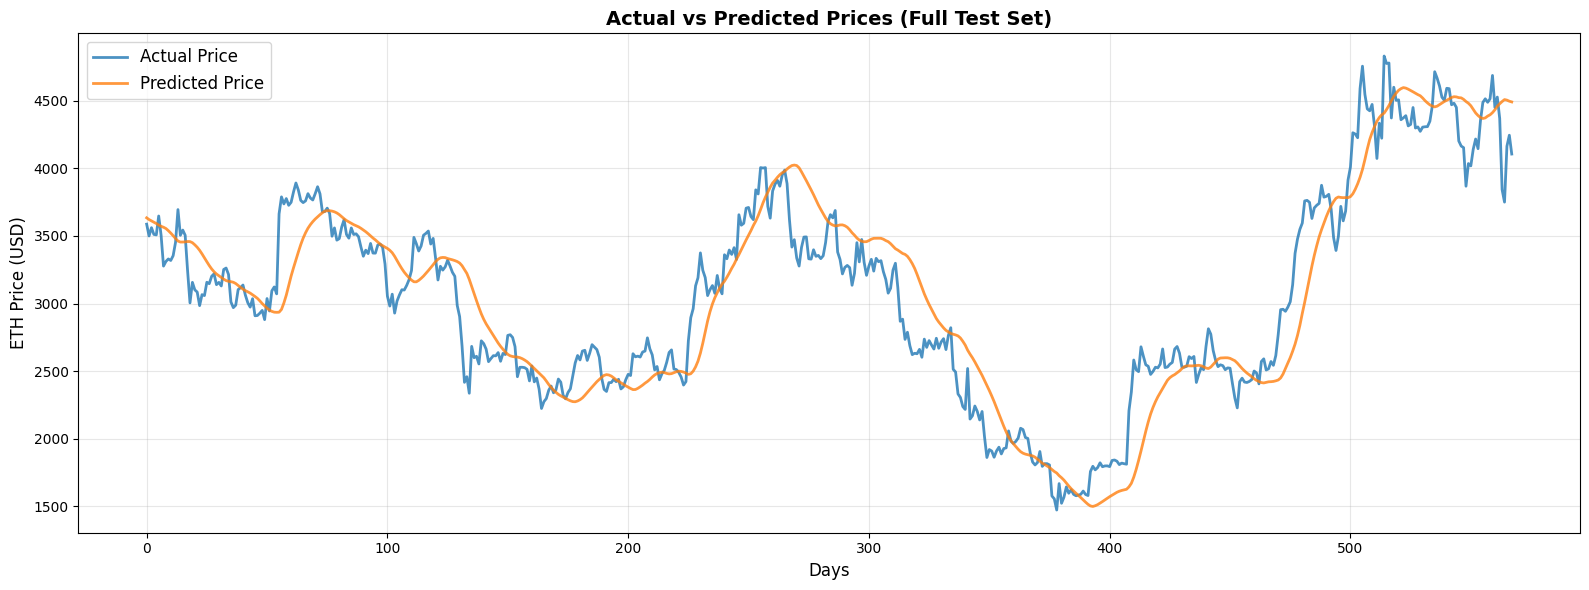

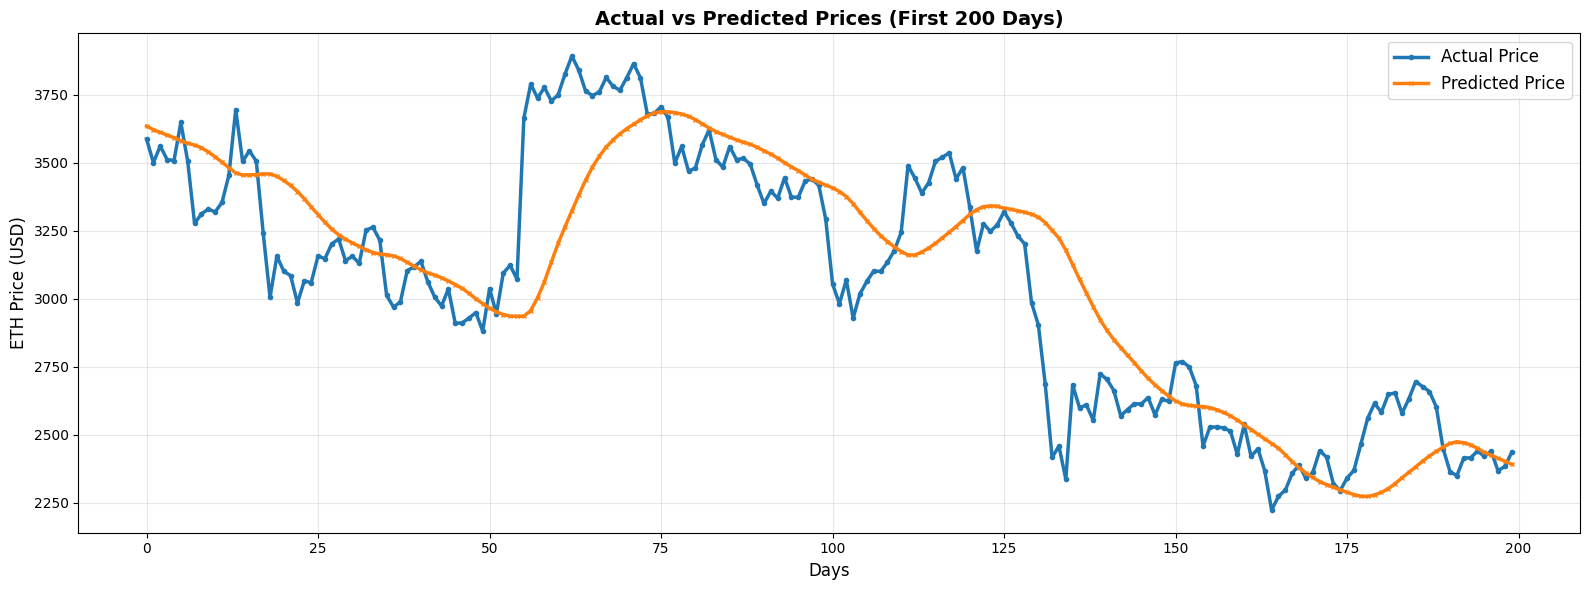

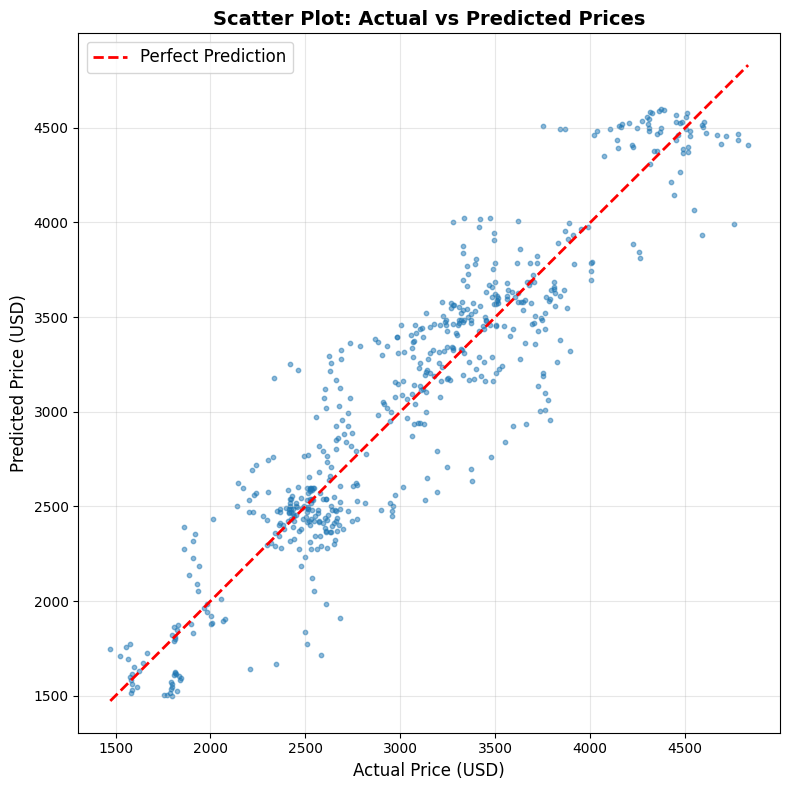

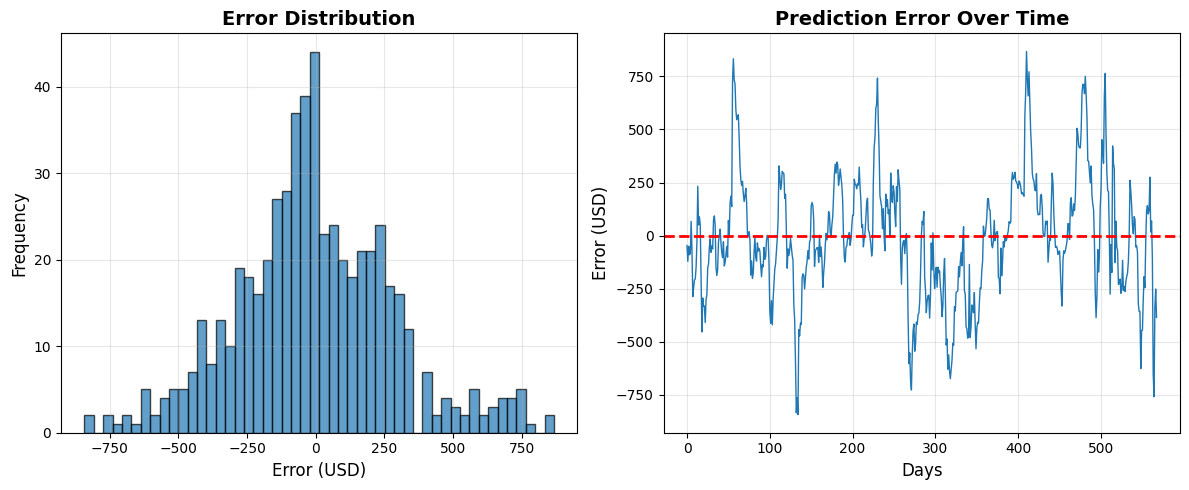

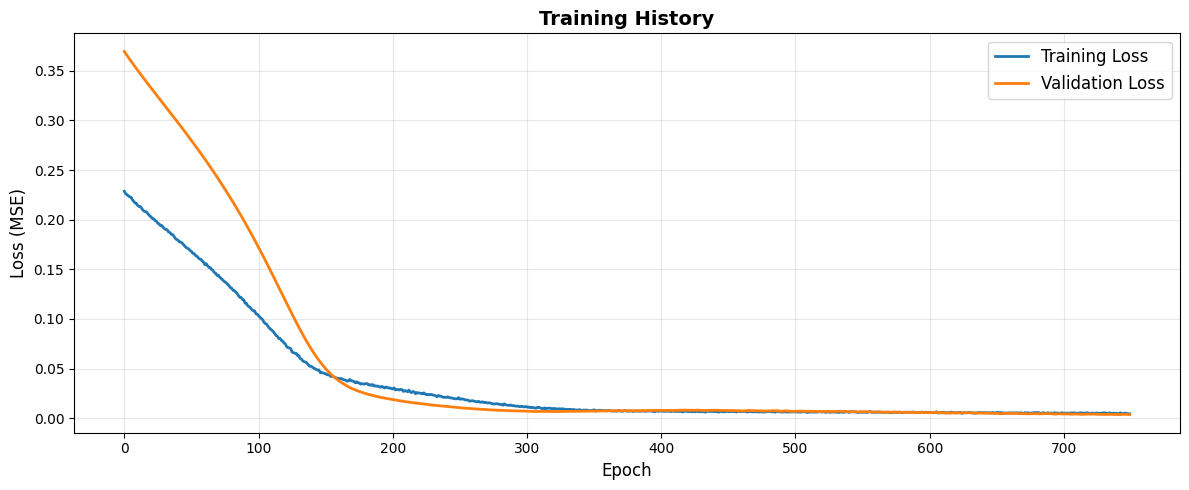


✅ Done! Model successfully predicted ETH prices


In [20]:
# ==================== Predict Future Prices ====================

# 1. Predict on test set
model.eval()
with torch.no_grad():
    y_pred_scaled = model(X_test).cpu().numpy()
    y_test_scaled = y_test.cpu().numpy()

# 2. Inverse transform to get real prices
y_pred_real = scaler_y.inverse_transform(y_pred_scaled)
y_test_real = scaler_y.inverse_transform(y_test_scaled)

# 3. Print summary
print("="*70)
print("📊 ETH-USD Price Prediction Results")
print("="*70)
print(f"Total data points: {len(df):,} days")
print(f"Training data: {len(X_train):,} days")
print(f"Testing data: {len(X_test):,} days")

# 4. Calculate accuracy metrics
mse = np.mean((y_test_real - y_pred_real) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_test_real - y_pred_real))
mape = np.mean(np.abs((y_test_real - y_pred_real) / y_test_real)) * 100

print(f"\n📈 Model Accuracy:")
print(f"RMSE: ${rmse:,.2f}")
print(f"MAE:  ${mae:,.2f}")
print(f"MAPE: {mape:.2f}%")

# 5. Show prediction examples
print(f"\n📋 Prediction Examples (First 10 days of Test Set):")
print("-"*70)
print(f"{'Index':<8} {'Actual Price':<15} {'Predicted Price':<15} {'Difference':<15}")
print("-"*70)

for i in range(min(10, len(y_test_real))):
    real = y_test_real[i][0]
    pred = y_pred_real[i][0]
    diff = real - pred
    print(f"{i+1:<8} ${real:>12,.2f} ${pred:>12,.2f} ${diff:>12,.2f}")

print("-"*70)

# 6. Show last 10 days
print(f"\n📌 Last 10 Days Predictions:")
print("-"*70)
print(f"{'Index':<8} {'Actual Price':<15} {'Predicted Price':<15} {'Difference':<15}")
print("-"*70)

for i in range(max(0, len(y_test_real)-10), len(y_test_real)):
    real = y_test_real[i][0]
    pred = y_pred_real[i][0]
    diff = real - pred
    idx = i - (len(y_test_real) - 10)
    print(f"{idx+1:<8} ${real:>12,.2f} ${pred:>12,.2f} ${diff:>12,.2f}")

print("="*70)

# ==================== Plot Graphs ====================

# Graph 1: Compare Actual vs Predicted (All data)
plt.figure(figsize=(16, 6))
plt.plot(y_test_real, label='Actual Price', linewidth=2, alpha=0.8)
plt.plot(y_pred_real, label='Predicted Price', linewidth=2, alpha=0.8)
plt.xlabel('Days', fontsize=12)
plt.ylabel('ETH Price (USD)', fontsize=12)
plt.title('Actual vs Predicted Prices (Full Test Set)', fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Graph 2: Zoom into first 200 days
plt.figure(figsize=(16, 6))
n_show = min(200, len(y_test_real))
plt.plot(y_test_real[:n_show], label='Actual Price', linewidth=2.5, marker='o', markersize=3)
plt.plot(y_pred_real[:n_show], label='Predicted Price', linewidth=2.5, marker='x', markersize=3)
plt.xlabel('Days', fontsize=12)
plt.ylabel('ETH Price (USD)', fontsize=12)
plt.title(f'Actual vs Predicted Prices (First {n_show} Days)', fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Graph 3: Scatter plot (Actual vs Predicted)
plt.figure(figsize=(8, 8))
plt.scatter(y_test_real, y_pred_real, alpha=0.5, s=10)
plt.plot([y_test_real.min(), y_test_real.max()],
         [y_test_real.min(), y_test_real.max()],
         'r--', linewidth=2, label='Perfect Prediction')
plt.xlabel('Actual Price (USD)', fontsize=12)
plt.ylabel('Predicted Price (USD)', fontsize=12)
plt.title('Scatter Plot: Actual vs Predicted Prices', fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Graph 4: Error Distribution
errors = y_test_real.flatten() - y_pred_real.flatten()
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(errors, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Error (USD)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Error Distribution', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(errors, linewidth=1)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Days', fontsize=12)
plt.ylabel('Error (USD)', fontsize=12)
plt.title('Prediction Error Over Time', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Graph 5: Training History
plt.figure(figsize=(12, 5))
plt.plot(train_losses, label='Training Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training History', fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✅ Done! Model successfully predicted ETH prices")

The training and validation loss plot shows the model's performance over epochs, and the predictions vs actual plot illustrates how well the model's predictions align with the actual values.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c77ad26d-d81f-4109-ae7f-7b27fc6fbdbc' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>